In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D
from keras.optimizers import Adam
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
import scipy.fftpack as fp
from skimage.io import imread
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical


In [2]:
f_au = open("coverage_au_list.txt", "w")
f_tp = open("coverage_tp_list.txt", "w")

for i in range(1,100):
    f_au.write(str(i)+".tif\n")
    f_tp.write(str(i)+"t.tif\n")
f_au.write("100.tif")
f_tp.write("100t.tif")


f_au.close()
f_tp.close()


In [3]:
#tp = pd.read_csv('coverage_tp_list.txt', header=None)
#au = pd.read_csv('coverage_au_list.txt', header=None)
tp = pd.read_csv('cmfd_tp_list.txt', header=None)
au = pd.read_csv('au_list.txt', header=None)
#file_path_au = "C:\\Users\\jakub\\Desktop\\Au"
file_path_au = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\Au"
#file_path_tp = "C:\\Users\\jakub\\Desktop\\Tp"
file_path_tp = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\Tp"
au[0] = file_path_au + "\\" + au[0]
tp[0] = file_path_tp + "\\" + tp[0]
au.columns = ['file_path']
tp.columns = ['file_path']
au['type'] = 'Authentic'
tp['type'] = 'Forged'

In [4]:
au = au.head(1000)
tp = tp.head(1000)

In [5]:
im_df = pd.concat([au, tp], ignore_index=True)

In [6]:
from sklearn.cluster import DBSCAN


def preprocess_image(image_path, output_size=(224, 224)):
    # Load the image in RGB
    img = cv2.imread(image_path)
    img = cv2.resize(img, output_size)

    # Initialize ORB detector with more keypoints for higher sensitivity
    orb = cv2.ORB_create(nfeatures=20000)
    keypoints, descriptors = orb.detectAndCompute(img, None)

    # Check if keypoints were detected
    if descriptors is None or len(keypoints) < 2:
        print("Not enough keypoints detected!")
        return np.zeros(img.shape, dtype=np.uint8)

    # Create a BFMatcher for ORB
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors using BFMatcher
    matches = bf.match(descriptors, descriptors)

    # Filter matches based on stricter spatial proximity
    filtered_matches = []
    for match in matches:
        pt1 = np.array(keypoints[match.queryIdx].pt)
        pt2 = np.array(keypoints[match.trainIdx].pt)
        if np.linalg.norm(pt1 - pt2) < 30:  # Reduced distance threshold
            filtered_matches.append(match)

    # Prepare points for clustering
    match_points = []
    for match in filtered_matches:
        pt1 = np.round(keypoints[match.queryIdx].pt).astype(int)
        pt2 = np.round(keypoints[match.trainIdx].pt).astype(int)
        match_points.append(pt1)
        match_points.append(pt2)

    match_points = np.array(match_points)

    # Apply DBSCAN clustering with tighter parameters
    if len(match_points) > 0:
        clustering = DBSCAN(eps=10, min_samples=5).fit(match_points)
        clustered_points = match_points[clustering.labels_ != -1]
    else:
        clustered_points = []

    # Create a blank binary map
    forgery_map = np.zeros(img.shape[:2], dtype=np.uint8)

    # Draw clustered keypoints on the binary map
    for pt in clustered_points:
        cv2.circle(forgery_map, tuple(pt), 3, 255, -1)

    # Apply refined morphological operations for better smoothing
    kernel = np.ones((7, 7), np.uint8)
    forgery_map = cv2.morphologyEx(forgery_map, cv2.MORPH_CLOSE, kernel)
    forgery_map = cv2.GaussianBlur(forgery_map, (7, 7), 0)

    # Normalize the binary map to 0 and 1
    forgery_map = cv2.normalize(forgery_map, None, 0, 1, cv2.NORM_MINMAX)

    # Multiply the binary map by the original RGB image for output
    forgery_map_rgb = (forgery_map[..., np.newaxis] * img).astype(np.uint8)

    return forgery_map_rgb



In [65]:
'''
from scipy.spatial.distance import cosine

def preprocess_image(image_path, output_size=(224, 224), block_size=32):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, output_size)

    # Prepare a blank binary map
    forgery_map = np.zeros(img.shape, dtype=np.uint8)

    # Divide the image into blocks with reduced overlap
    height, width = img.shape
    blocks = []
    block_positions = []

    for y in range(0, height - block_size + 1, block_size):
        for x in range(0, width - block_size + 1, block_size):
            block = img[y:y+block_size, x:x+block_size]
            # Apply Discrete Cosine Transform (DCT) for feature extraction
            dct_block = cv2.dct(block.astype(np.float32))
            blocks.append(dct_block.flatten())
            block_positions.append((x, y))

    # Convert blocks to a NumPy array
    blocks = np.array(blocks)

    # Compute similarity using cosine distance between blocks
    for i in range(len(blocks)):
        for j in range(i + 1, len(blocks)):
            similarity = 1 - cosine(blocks[i], blocks[j])
            if similarity > 0.995:  # Stricter similarity threshold
                x1, y1 = block_positions[i]
                x2, y2 = block_positions[j]
                cv2.rectangle(forgery_map, (x1, y1), (x1 + block_size, y1 + block_size), 255, -1)
                cv2.rectangle(forgery_map, (x2, y2), (x2 + block_size, y2 + block_size), 255, -1)

    # Apply refined morphological operations for smoothing
    kernel = np.ones((7, 7), np.uint8)
    forgery_map = cv2.morphologyEx(forgery_map, cv2.MORPH_CLOSE, kernel)
    forgery_map = cv2.GaussianBlur(forgery_map, (7, 7), 0)

    # Normalize the binary map to 0 and 1
    forgery_map = cv2.normalize(forgery_map, None, 0, 1, cv2.NORM_MINMAX)

    return forgery_map * img
    '''

In [7]:
def save_image():
    labels = []
    imgs = []
    
    for i in range(len(im_df)):
        labels.append(im_df['type'][i]) 
        f_map = preprocess_image(im_df['file_path'][i]) 
        imgs.append(f_map)
    
    return labels, imgs

In [8]:
#odzyskiwanie ramu
del tp
del au
del file_path_au
del file_path_tp

In [9]:
labels, imgs = save_image()

Not enough keypoints detected!


In [10]:
#odzyskiwanie ramu
del im_df

In [11]:
u = list(np.unique(labels)) #lsita unikalnych wartości w labels (red, green, other)

ilabels = np.asarray([u.index(l) for l in labels]) #utworzenie nowej listy zawierającyh wartości unikalne w postaci liczb, a nie tekstu

In [12]:
#odzyskiwanie ramu
del u
del labels

Kodu niżej nie uruchmiać jeśli nie ma się 32 GB RAMU, bo freezuje komputer

In [13]:
X = np.stack(imgs) / 255.0 - 0.5 #połączenie wszystkich osobnych list zawarty w imgs w jedną podzielenie wartości przez 255, ay otrzymać wartości od 0 do 1 i pomniejszenie wartości o 0.5 i otrzymanie od -0.5 do 0.5

In [14]:
del imgs

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, ilabels, test_size=0.33, shuffle=True, random_state=42) #podzielenie danych na treningowe i testowe, jak wyżej

In [16]:
del X
del ilabels

In [17]:
# Tworzenie modelu Sequential
input_shape = (224, 224, 3)

# Define the CNN model
model = Sequential([
        # Pierwsza warstwa splotowa
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        # Druga warstwa splotowa
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Trzecia warstwa splotowa
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Czwarta warstwa splotowa
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Dropout(0.5),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        # Output layer
        Dense(1, activation='sigmoid')
])

# Kompilacja modelu z dodatkowymi metrykami
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy', AUC(name="AUC"), Precision(name="Precision"), Recall(name="Recall"), keras.metrics.TruePositives(name="TP"), keras.metrics.TrueNegatives(name="TN")])

# Podsumowanie modelu
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [18]:
h = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=2, validation_data=(X_test, y_test))

Epoch 1/20
168/168 - 64s - loss: 0.6764 - accuracy: 0.5679 - AUC: 0.6118 - Precision: 0.5522 - Recall: 0.6842 - TP: 455.0000 - TN: 306.0000 - val_loss: 0.6610 - val_accuracy: 0.5758 - val_AUC: 0.7573 - val_Precision: 0.8667 - val_Recall: 0.1940 - val_TP: 65.0000 - val_TN: 315.0000 - 64s/epoch - 378ms/step
Epoch 2/20
168/168 - 61s - loss: 0.6454 - accuracy: 0.6291 - AUC: 0.6645 - Precision: 0.6615 - Recall: 0.5173 - TP: 344.0000 - TN: 499.0000 - val_loss: 0.6522 - val_accuracy: 0.5909 - val_AUC: 0.7542 - val_Precision: 0.8421 - val_Recall: 0.2388 - val_TP: 80.0000 - val_TN: 310.0000 - 61s/epoch - 365ms/step
Epoch 3/20
168/168 - 65s - loss: 0.5987 - accuracy: 0.6836 - AUC: 0.7373 - Precision: 0.7313 - Recall: 0.5729 - TP: 381.0000 - TN: 535.0000 - val_loss: 0.5836 - val_accuracy: 0.7121 - val_AUC: 0.8000 - val_Precision: 0.6747 - val_Recall: 0.8358 - val_TP: 280.0000 - val_TN: 190.0000 - 65s/epoch - 386ms/step
Epoch 4/20
168/168 - 62s - loss: 0.5630 - accuracy: 0.7082 - AUC: 0.7765 - Pre

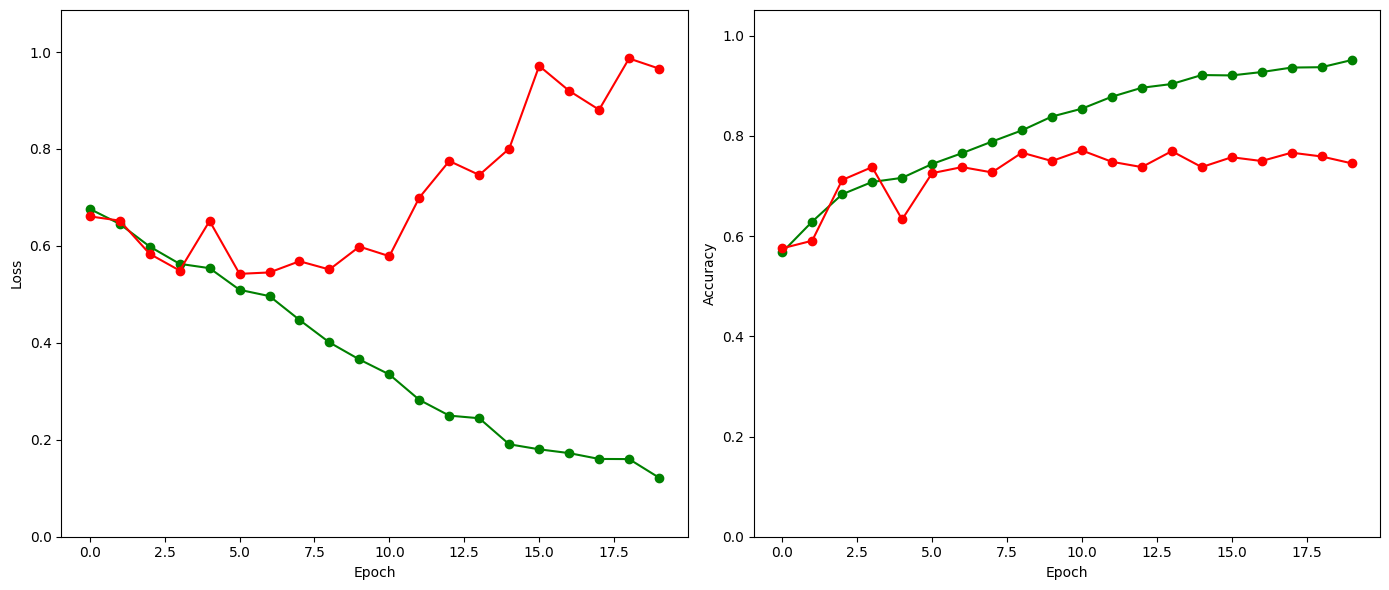

Training history with confidence intervals saved as training_cmfd_rgb.svg


In [19]:
# Tworzenie DataFrame z historii trenowania
history_df = pd.DataFrame(h.history)

# Obliczanie przedziałów ufności (np. 95%)
confidence_interval = 0.95
ci_bounds = int((1 - confidence_interval) * 100 / 2)

# Funkcja do obliczania przedziału ufności
def compute_confidence_interval(values):
    mean = np.mean(values)
    std = np.std(values)
    ci_range = std * 1.96  # 95% przedział ufności
    return mean - ci_range, mean + ci_range

# Tworzenie wykresów
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres dla loss
axes[0].plot(history_df['loss'], label='Loss', color='green', marker='o')
axes[0].plot(history_df['val_loss'], label='Loss', color='red', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_ylim(0, max(history_df[['loss', 'val_loss']].max()) + 0.1)  # Skala od 0

# Wykres dla accuracy
axes[1].plot(history_df['accuracy'], label='Accuracy', color='green', marker='o')
axes[1].plot(history_df['val_accuracy'], label='Accuracy', color='red', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, max(history_df[['accuracy', 'val_accuracy']].max()) + 0.1)  # Skala od 0
# Zapis do pliku SVG
plt.tight_layout()
plt.savefig('training_cmfd_rgb.svg', format='svg')
plt.show()

print("Training history with confidence intervals saved as training_cmfd_rgb.svg")


In [20]:
history_df.to_csv('cmfd_rgb.csv', index=False)

In [21]:
history_df

,loss,accuracy,AUC,Precision,Recall,TP,TN,val_loss,val_accuracy,val_AUC,val_Precision,val_Recall,val_TP,val_TN
0,0.676443,0.567910,0.611850,0.552184,0.684211,455.0,306.0,0.660952,0.575758,0.757327,0.866667,0.194030,65.0,315.0
1,0.645391,0.629104,0.664515,0.661538,0.517293,344.0,499.0,0.652189,0.590909,0.754158,0.842105,0.238806,80.0,310.0
2,0.598746,0.683582,0.737263,0.731286,0.572932,381.0,535.0,0.583635,0.712121,0.800009,0.674699,0.835821,280.0,190.0
3,0.563032,0.708209,0.776475,0.737024,0.640602,426.0,523.0,0.549254,0.737879,0.812565,0.785211,0.665672,223.0,264.0
4,0.554090,0.716418,0.794657,0.739496,0.661654,440.0,520.0,0.651461,0.633333,0.799541,0.854962,0.334328,112.0,306.0
5,0.509431,0.744030,0.822624,0.769231,0.691729,460.0,537.0,0.542371,0.725758,0.830866,0.791667,0.623881,209.0,270.0
6,0.496434,0.765672,0.837698,0.796954,0.708271,471.0,555.0,0.545292,0.737879,0.827513,0.705584,0.829851,278.0,209.0
7,0.447304,0.788806,0.866002,0.815181,0.742857,494.0,563.0,0.568397,0.727273,0.824588,0.832618,0.579104,194.0,286.0
8,0.400824,0.811194,0.897165,0.853952,0.747368,497.0,590.0,0.551353,0.766667,0.832730,0.773414,0.764179,256.0,250.0
9,0.365675,0.838806,0.913773,0.865041,0.800000,532.0,592.0,0.598592,0.750000,0.820165,0.797203,0.680597,228.0,267.0


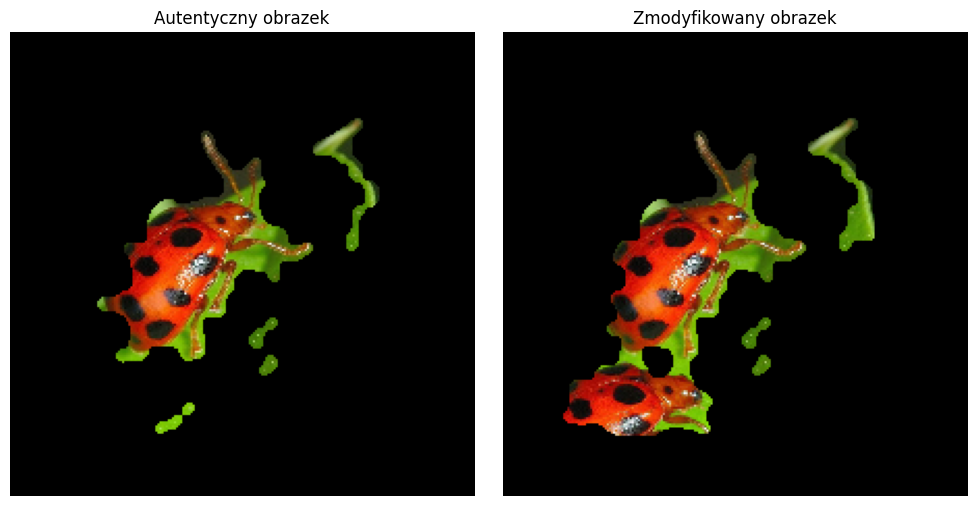

In [ ]:
# Ścieżki do obrazów
image_path1 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\Au\\Au_ani_10206.jpg"
image_path2 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\Tp\\Tp_S_CNN_M_N_ani10206_ani10206_12414.jpg"
#image_path1 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\Au\\Au_ani_00087.jpg"
#image_path2 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\Tp\\Tp_S_NNN_S_N_ani00087_ani00087_00814.tif"
#image_path1 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\COVERAGE\\image\\42.tif"
#image_path2 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\COVERAGE\\image\\42t.tif"
#image_path1 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\COVERAGE\\image\\10.tif"
#image_path2 = "D:\\Studia\\Cyber Sem II\\BezpTrMult\\COVERAGE\\image\\10t.tif"
# Przetwarzanie obrazów
processed_image1 = preprocess_image(image_path1)
processed_image2 = preprocess_image(image_path2)

# Wyświetlanie obrazów
plt.figure(figsize=(10, 5))

# Obraz 1
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(processed_image1, cv2.COLOR_BGR2RGB))
plt.title('Autentyczny obrazek')
plt.axis('off')

# Obraz 2
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(processed_image2, cv2.COLOR_BGR2RGB))
plt.title('Zmodyfikowany obrazek')
plt.axis('off')

plt.tight_layout()
plt.savefig('cmfd_rgb.svg', format='svg')
plt.show()
